# 10. Attention Mechanisms

## 10.1. Attention Cues

### 10.1.3. Visualization

In [1]:
import torch
from d2l import torch as d2l

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
    sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

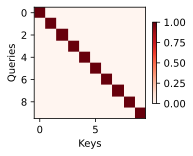

In [3]:
attention_weights = torch.eye(10).reshape((1,1,10,10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel="Queries")

## 10.2. Attention Pooling: Nadaraya-Watson Kernel Regression

In [4]:
from torch import nn

### 10.2.1. Generating the Dataset

In [5]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

In [6]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

In [7]:
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [8]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x','y', legend=['Truth', 'Pred'],
    xlim=[0,5], ylim=[-1,5])
    d2l.plt.plot(x_train, y_train,'o', alpha=0.5)

### 10.2.2. Average Pooling

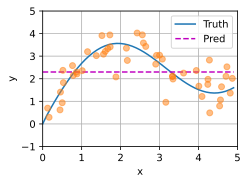

In [9]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 10.2.3. Nonparameteric Attention Pooling

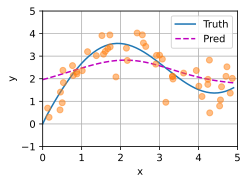

In [10]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim = 1)

y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

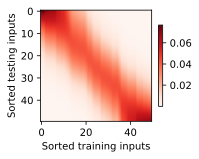

In [11]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

### 10.2.4. Parametric Attention Pooling

#### Batch Matrix Multiplication

In [13]:
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [14]:
weights = torch.ones((2,10)) * 0.1
values = torch.arange(20.0).reshape((2,10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

#### Defining the Model

In [19]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1,), requires_grad=True)

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        
        return torch.bmm(self.attention_weights.unsqueeze(1),
                        values.unsqueeze(-1)).reshape(-1)


In [20]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

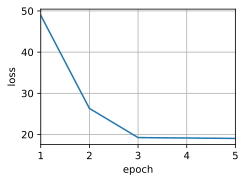

In [21]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

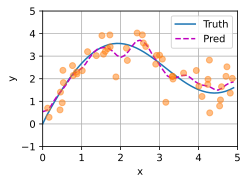

In [22]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

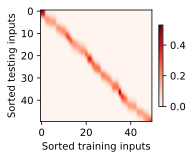

In [23]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
xlabel='Sorted training inputs',
ylabel='Sorted testing inputs')

## 10.3. Attention Scoring Functions

In [25]:
import math

In [26]:
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)

        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [27]:
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.4876, 0.5124, 0.0000, 0.0000],
         [0.6740, 0.3260, 0.0000, 0.0000]],

        [[0.3552, 0.2748, 0.3700, 0.0000],
         [0.3003, 0.4583, 0.2414, 0.0000]]])

In [28]:
masked_softmax(torch.rand(2,2,4), torch.tensor([[1,3],[2,4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3402, 0.3322, 0.3275, 0.0000]],

        [[0.4198, 0.5802, 0.0000, 0.0000],
         [0.1725, 0.2800, 0.3204, 0.2271]]])

### 10.3.2. Additive Attention

In [29]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)

        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        
        return torch.bmm(self.dropout(self.attention_weights), values)

In [30]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))

values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

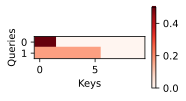

In [31]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
xlabel='Keys', ylabel='Queries')

### 10.3.3. Scaled Dot-Product Attention

In [32]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
   
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [33]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

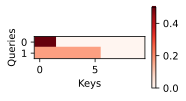

In [34]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
xlabel='Keys', ylabel='Queries')

## 10.4. Bahdanau Attention

### 10.4.1. Model

In [35]:
class AttentionDecoder(d2l.Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

In [38]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
        num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
        embed_size + num_hiddens, num_hiddens, num_layers,
        dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
    
        enc_outputs, hidden_state, enc_valid_lens = state
        
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []

        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
        
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
        
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
        
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
        enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [39]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

### 10.4.3. Training

loss 0.020, 8757.0 tokens/sec on cuda:0


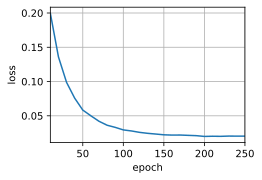

In [40]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [41]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est paresseux .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [43]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
1, 1, -1, num_steps))

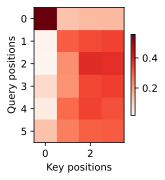

In [44]:
d2l.show_heatmaps(
attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
xlabel='Key positions', ylabel='Query positions')